In [11]:
import tensorflow as tf
import numpy as np
from NeuralFlow.flow import Flow_v2

In [12]:
def create_base_model(input_shape=1, output_shape=1):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)


In [13]:
flow = Flow_v2(
    model_fn = create_base_model,
    n_models = 10,
    noise_stddev=1e-4, 
    lam = 1e-2)

In [14]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


def optimizer_fn():
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.96)
    return tf.keras.optimizers.Adam(lr_scheduler)

flow.compile(optimizer_fn=optimizer_fn, loss_fn=loss_fn, metrics=['mae'])

In [15]:
X_train = tf.cast(np.linspace(0, 1, 1000).reshape(-1, 1), tf.float32)
y_train = tf.cast(np.sin(X_train * 2 * np.pi).reshape(-1, 1), tf.float32)

batch_size = 32
loader_size = X_train.shape[0] // batch_size

In [16]:
flow.fit(X_train, y_train, batch_size=batch_size, epochs=50)

Epoch 1/50


32/32 - 1s - 35ms/step - loss: 1667.1449 - mae: 0.5007
Epoch 2/50
32/32 - 0s - 4ms/step - loss: 562.6332 - mae: 0.2798
Epoch 3/50
32/32 - 0s - 4ms/step - loss: 375.1746 - mae: 0.1875
Epoch 4/50
32/32 - 0s - 5ms/step - loss: 296.8477 - mae: 0.1434
Epoch 5/50
32/32 - 0s - 5ms/step - loss: 274.3275 - mae: 0.1212
Epoch 6/50
32/32 - 0s - 5ms/step - loss: 266.9654 - mae: 0.1237
Epoch 7/50
32/32 - 0s - 5ms/step - loss: 261.6968 - mae: 0.1235
Epoch 8/50
32/32 - 0s - 5ms/step - loss: 255.9516 - mae: 0.1270
Epoch 9/50
32/32 - 0s - 5ms/step - loss: 247.3801 - mae: 0.1229
Epoch 10/50
32/32 - 0s - 5ms/step - loss: 238.8795 - mae: 0.1256
Epoch 11/50
32/32 - 0s - 5ms/step - loss: 226.1429 - mae: 0.1233
Epoch 12/50
32/32 - 0s - 5ms/step - loss: 213.3735 - mae: 0.1152
Epoch 13/50
32/32 - 0s - 4ms/step - loss: 199.9887 - mae: 0.1162
Epoch 14/50
32/32 - 0s - 4ms/step - loss: 183.9510 - mae: 0.1148
Epoch 15/50
32/32 - 0s - 5ms/step - loss: 162.8533 - mae: 0.1064
Epoch 16/50
32/32 - 0s - 6ms/step - loss: 1

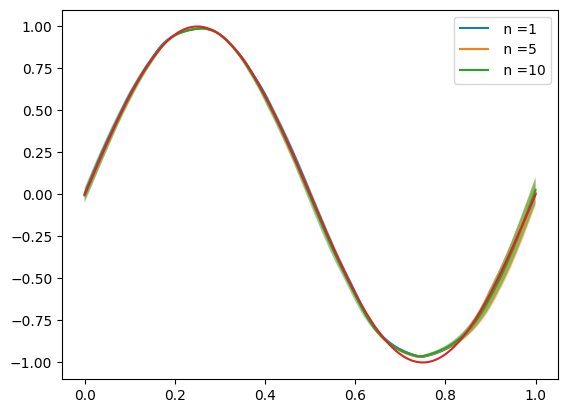

In [17]:
import matplotlib.pyplot as plt


fig = plt.figure()
for n in [1, 5, 10]:
    est = flow.get_estimator("deep_ensemble", n_models = n)
    mean, var = est(X_train)

    # for model in flow.models:
    #     plt.plot(X_train, model(X_train), alpha=0.5)

    plt.plot(X_train, mean.squeeze(), label = f" n ={n}")
    plt.fill_between(tf.squeeze(X_train), mean.squeeze() - 1.96 * np.sqrt(var.squeeze()),  mean.squeeze() + 1.96 * np.sqrt(var.squeeze()), alpha=0.5)


plt.plot(X_train, y_train)
plt.legend()
plt.show()